In [46]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df
#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

,date,price,wallets,address,mined
0,2010-09-25,0.1,2,656.0,4109450.00
1,2010-09-26,0.1,2,444.0,4110750.00
2,2010-09-27,0.1,2,1070.0,4132150.00
3,2010-09-28,0.1,2,1503.0,4133200.00
4,2010-09-29,0.1,2,1049.0,4148050.00
...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25


In [47]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [48]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,67579.622795,57609.730004,76961.156298
5112,2024-10-21,67786.517389,58350.513994,77369.753708
5113,2024-10-22,67956.169026,58701.377900,77816.430642
5114,2024-10-23,68193.892712,58105.824548,78288.677952
5115,2024-10-24,68339.782496,58046.624252,78179.183434


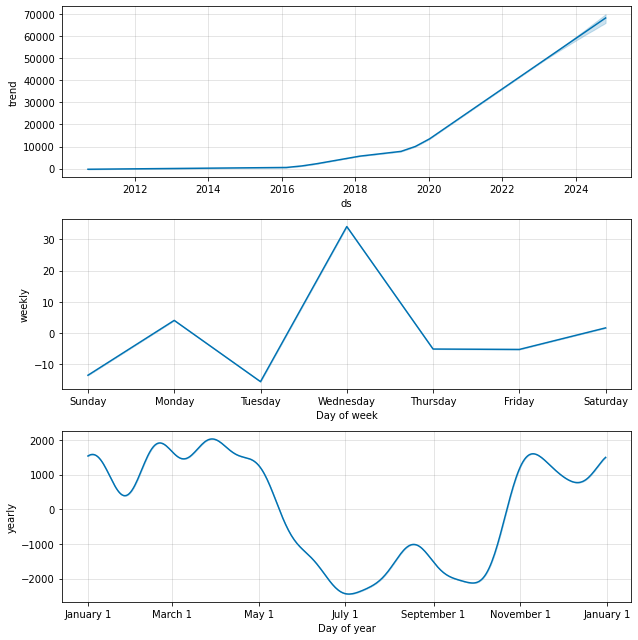

In [50]:
fig2 = m.plot_components(forecast)

In [51]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing
12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


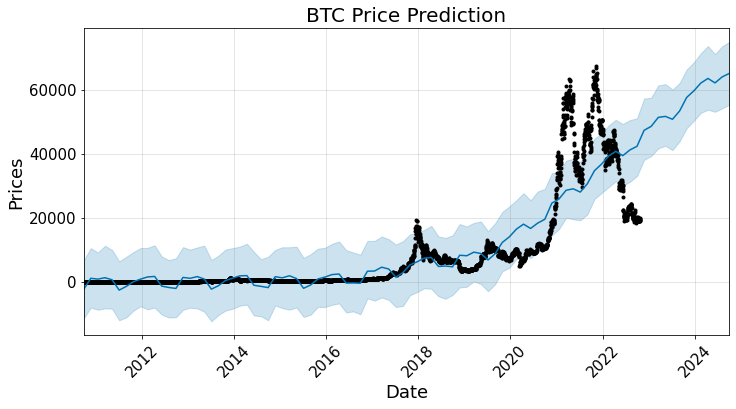

In [52]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-10-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-10-01'])) 
plt.show();
# plt.savefig("../static/prices.png")

In [53]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_train['ds'], y=df_train['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=prediction['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=prediction['yhat_lower'], legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=prediction['yhat_upper'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.show()
fig.write_html('../static/prices.html')

In [54]:
#https://www.kaggle.com/code/manovirat/timeseries-using-prophet-hyperparameter-tuning
# hyperparameter-tuning

In [55]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_train.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [56]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(r2_score(metric_df.y, metric_df.yhat))
print(mean_squared_error(metric_df.y, metric_df.yhat))
print(mean_absolute_error(metric_df.y, metric_df.yhat))

0.7455600523204606
54484853.20594275
4327.367657467535


In [57]:
end_date = '2021-12-31'
mask1 = (df_train['ds'] <= end_date)
mask2 = (df_train['ds'] > end_date)

In [58]:
X_tr = df_train.loc[mask1]
X_tst = df_train.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (4088, 2)
test shape (298, 2)


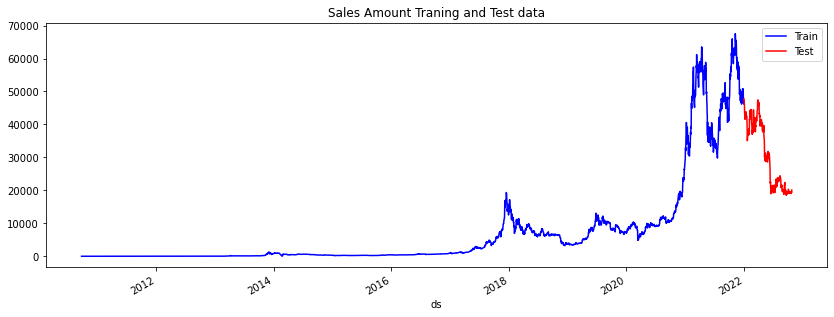

In [59]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [60]:
model =Prophet()
model.fit(X_tr)

12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
future = model.make_future_dataframe(periods=150, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
4231,2022-05-24,63297.793011,57717.875988,69585.867884
4232,2022-05-25,63289.499412,57283.464713,69713.600490
4233,2022-05-26,63256.026518,57553.970033,69300.432437
4234,2022-05-27,63274.384866,57441.481445,69387.421211
4235,2022-05-28,63306.855090,57411.725743,69916.256142
4236,2022-05-29,63320.701353,57436.051846,69459.721680
4237,2022-05-30,63358.663891,57448.838739,69369.825539


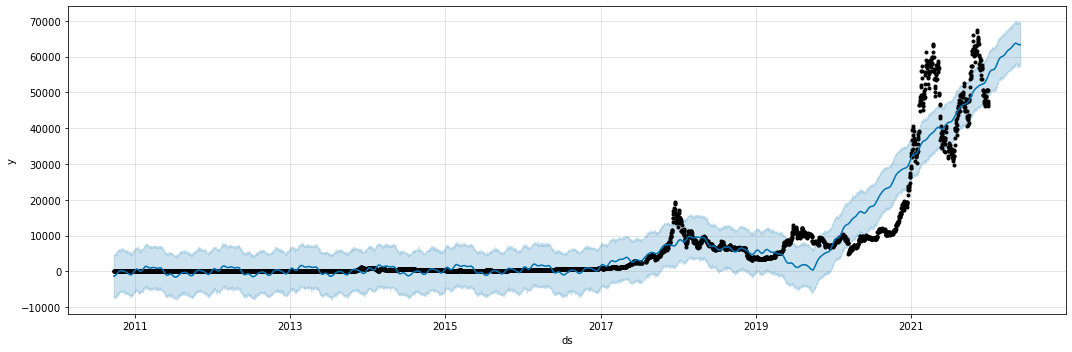

In [62]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [63]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
291,2022-10-19,73498.997504,67385.214733,79561.781735
292,2022-10-20,73586.003959,67437.387983,79654.446275
293,2022-10-21,73711.477113,67349.691888,79768.676215
294,2022-10-22,73837.043487,67421.268956,79879.213788
295,2022-10-23,73929.568774,67287.120703,80176.649424
296,2022-10-24,74031.654217,67111.053461,80345.946047
297,2022-10-25,74089.331749,67662.533452,80609.992200


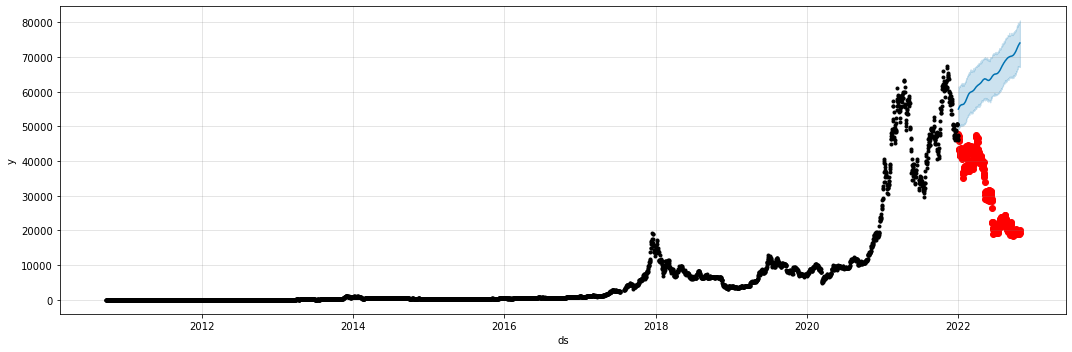

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

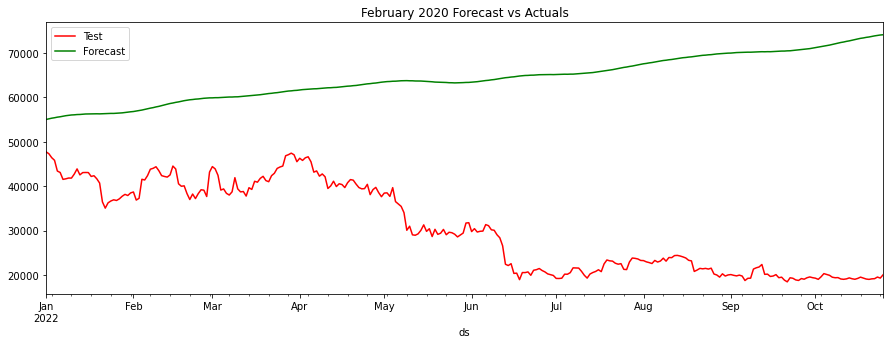

In [65]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [66]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [67]:
import random
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [68]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
291,2022-10-19,73434.221336,67308.272017,80073.285848
292,2022-10-20,73519.687515,67035.648557,79543.084571
293,2022-10-21,73638.687005,67361.930536,80020.372081
294,2022-10-22,73760.330768,67632.980934,79863.958564
295,2022-10-23,73850.944856,67468.237215,79862.026815
296,2022-10-24,73993.952200,67751.846013,80232.395747
297,2022-10-25,74010.949958,67980.905820,80485.631963


In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 138.1023
